In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, special, optimize

from infohdp.generators import gen_prior_pij, gen_prior_pij_t, gen_samples_prior, gen_samples_prior_t
from infohdp.core import entropy_true, mutual_information_true
from infohdp.utils import count_nxy_multiclass
from infohdp.estimators import NaiveEstimator, NSBEstimator, BinaryInfoHDPEstimator, MulticlassInfoHDPEstimator, BinaryFullInfoHDPEstimator, MulticlassFullInfoHDPEstimator

# Or import the whole package as "import infohdp"

In [20]:
# Example 1: Generate prior pij, binary case
alpha = 150.0
beta = 3.0
Ns = 5000

# Example 2: Generate prior pij_t, multiclass case
qy = [0.5, 0.3, 0.2]  # Example marginal distribution for Y
pi, pjdadoi, pij_t = gen_prior_pij_t(alpha, beta, qy, Ns)

In [21]:
print(pij_t.shape)

print(f"True entropy: {entropy_true(pij_t):.4f}")
print(f"Effective number of states: {np.exp(entropy_true(pij_t)):.4f}")

# Set the seed
np.random.seed(1)
M = 500
samples_t = gen_samples_prior_t(pi,pjdadoi, M, Ns)

# Create instances of Estimators for multiclass case
naive_estimator = NaiveEstimator()
nsb_estimator = NSBEstimator()
ihdpt_estimator = MulticlassInfoHDPEstimator()
ihdpfull_estimator = MulticlassFullInfoHDPEstimator()

print(f"Naive entropy: {naive_estimator.estimate_entropy(samples_t):.4f}")
s_nsb, ds_nsb = nsb_estimator.estimate_entropy(samples_t)
print(f"NSB entropy: {s_nsb:.4f} ± {ds_nsb:.4f}")


print(f"True mutual information: {mutual_information_true(pij_t):.4f}")
print(f"Naive info: {naive_estimator.estimate_mutual_information(samples_t):.4f}")
i_nsb, di_nsb = nsb_estimator.estimate_mutual_information(samples_t)
print(f"NSB info: {i_nsb:.4f} ± {di_nsb:.4f}")
print(f"Ihdp(MAP)T info: {ihdpt_estimator.estimate_mutual_information(samples_t):.4f}")

i_hdp, di_hdp = ihdpfull_estimator.estimate_mutual_information(samples_t)
print(f"Ihdp full multiclass info: {i_hdp:.4f} ± {di_hdp:.4f}")


(5000, 3)
True entropy: 6.3313
Effective number of states: 561.9083
Naive entropy: 5.5184
NSB entropy: 6.3485 ± 0.0819
True mutual information: 0.2680
Naive info: 0.6172
NSB info: 0.3158 ± 0.1104
Ihdp(MAP)T info: 0.2123
Ihdp full multiclass info: 0.2094 ± 0.0513


In [ ]:
# Figure where we plot the average estimation of mutual information for different number of samples (from 50 to 2000, moving in log space) for the three estimators, naive, nsb and ihdp. For each number of samples we generate 20 sets of samples and compute the average and standard deviation of the estimation.

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def hdp_estimator(samples):
    estimator = MulticlassFullInfoHDPEstimator()
    i_hdp, _ = estimator.estimate_mutual_information(samples)
    return i_hdp

def nsb_estimator(samples):
    estimator = NSBEstimator()
    i_nsb, _ = estimator.estimate_mutual_information(samples)
    return i_nsb

def naive_estimator(samples):
    estimator = NaiveEstimator()
    i_naive = estimator.estimate_mutual_information(samples)
    return i_naive

def estimate_mutual_information(pi, pjdadoi, Ns, naive_estimator, nsb_estimator, hdp_estimator, sample_sizes):
    """
    Estimate mutual information using Naive Estimator, NSB Estimator, and HDP Estimator for different sample sizes.
    
    Parameters:
    - pi: Prior distribution parameter.
    - pjdadoi: Conditional distribution parameter.
    - Ns: Number of states.
    - naive_estimator: Function to estimate mutual information using Naive Estimator.
    - nsb_estimator: Function to estimate mutual information using NSB Estimator.
    - hdp_estimator: Function to estimate mutual information using HDP Estimator.
    - sample_sizes: List of sample sizes to use for estimation.
    
    Returns:
    - results: A dictionary containing the averaged mutual information estimates and standard deviations for each estimator.
    """
    
    results = {
        'naive': {'mean': [], 'std': []},
        'nsb': {'mean': [], 'std': []},
        'hdp': {'mean': [], 'std': []}
    }
    
    for sample_size in sample_sizes:
        naive_estimates = []
        nsb_estimates = []
        hdp_estimates = []
        
        for _ in range(5):  # Generate 20 sets of samples
            sample_data = gen_samples_prior_t(pi, pjdadoi, sample_size, Ns)
            
            naive_estimates.append(naive_estimator(sample_data))
            nsb_estimates.append(nsb_estimator(sample_data))
            hdp_estimates.append(hdp_estimator(sample_data))
        
        results['naive']['mean'].append(np.mean(naive_estimates))
        results['naive']['std'].append(np.std(naive_estimates))
        results['nsb']['mean'].append(np.mean(nsb_estimates))
        results['nsb']['std'].append(np.std(nsb_estimates))
        results['hdp']['mean'].append(np.mean(hdp_estimates))
        results['hdp']['std'].append(np.std(hdp_estimates))
    
    return results

# Example usage:
# Assuming you have defined functions naive_estimator, nsb_estimator, and hdp_estimator
# pi = ...  # Your prior distribution parameter
# pjdadoi = ...  # Your conditional distribution parameter
# Ns = ...  # Number of states
sample_sizes = np.logspace(np.log10(50), np.log10(2000), num=20, dtype=int)
# results = estimate_mutual_information(pi, pjdadoi, Ns, naive_estimator, nsb_estimator, hdp_estimator, sample_sizes)

In [23]:
results = estimate_mutual_information(pi, pjdadoi, Ns, naive_estimator, nsb_estimator, hdp_estimator, sample_sizes)

In [24]:
# Plotting the results
import matplotlib.pyplot as plt

def plot_results(results, sample_sizes, true_value=0.2803):
    """
    Plot the results of mutual information estimation.
    
    Parameters:
    - results: A dictionary containing the averaged mutual information estimates and standard deviations for each estimator.
    - sample_sizes: List of sample sizes used for estimation.
    - true_value: The true value of mutual information to plot as a reference line.
    """
    
    plt.figure(figsize=(10, 6))
    
    # Plot results for each estimator
    for estimator in results.keys():
        means = results[estimator]['mean']
        stds = results[estimator]['std']
        
        plt.errorbar(sample_sizes, means, yerr=stds, label=f'{estimator} estimator', capsize=5)
    
    # Add a dotted line at the true value
    plt.axhline(y=true_value, color='r', linestyle='--', label=f'True value ({true_value:.4f})')
    
    plt.xscale('log')
    plt.xlabel('Sample size')
    plt.ylabel('Mutual Information')
    plt.title('Mutual Information Estimation')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# plot_results(results, sample_sizes)

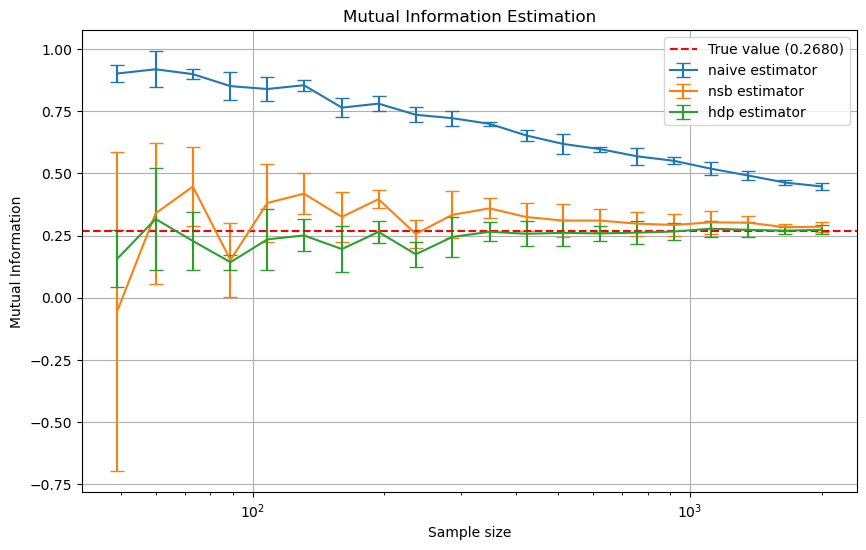

In [25]:
itrue = mutual_information_true(pij_t)
plot_results(results, sample_sizes, itrue)

### This next export is not working

In [ ]:
import pandas as pd

# Assuming 'results' is your dictionary containing the results
# and 'sample_sizes' is your list of sample sizes
# Example structure of results:
# results = {
#     'naive': {'mean': [0.1, 0.2, 0.3], 'std': [0.01, 0.02, 0.03]},
#     'nsb': {'mean': [0.15, 0.25, 0.35], 'std': [0.015, 0.025, 0.035]},
#     'hdp': {'mean': [0.2, 0.3, 0.4], 'std': [0.02, 0.03, 0.04]}
# }
# sample_sizes = [50, 100, 200]

# Ensure the lengths of the lists match
assert len(results['naive']['mean']) == len(results['naive']['std']) == len(sample_sizes)
assert len(results['nsb']['mean']) == len(results['nsb']['std']) == len(sample_sizes)
assert len(results['hdp']['mean']) == len(results['hdp']['std']) == len(sample_sizes)

# Create a DataFrame to hold all the results
data = {
    'sample_size': sample_sizes * 3,  # Repeat sample sizes for each estimator
    'mean': results['naive']['mean'] + results['nsb']['mean'] + results['hdp']['mean'],
    'std': results['naive']['std'] + results['nsb']['std'] + results['hdp']['std'],
    'estimator': ['naive'] * len(sample_sizes) + ['nsb'] * len(sample_sizes) + ['hdp'] * len(sample_sizes)
}

df_results = pd.DataFrame(data)


# Export the DataFrame to a CSV file
df_results.to_csv('results_synthetic.csv', index=False)

print("Results exported to results_synthetic.csv")